In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

## 2. Gravitational Orbits in Cartesian Coordinates
>a. Make a notebook that solves the two body problems for gravitational attraction between two bodies in Cartesian coordinates. Implement the differential equations as a Python class.
<br>b. Show that the problem reduces to the orbits considered in class if one of the bodies is very heavy and you are in its rest frame.
<br>c. Add Markdown/LaTeX documentation.
<br>d. Use the Leapfrog method to solve the differential equations and show that it conserves energy while using the SciPy ODE solvers do not?
<br>e. Extend the simulation to three bodies in the same plane and comment on the orbits you find.
<br>f. Add widgets to control the simulation and/or animate the orbits.


Energy Within Two Body Orbital Mechanics  
$\begin{align}
     T(\mathbf{\dot r}) &= \frac 12 \sum m_i(\dot x_i^2 + \dot y_i^2) \\
     U(\mathbf{r}) &= -\frac{G m_1 m_2}{\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}} \\     
\end{align}$
 
 
The Lagrange's Equation:  
$\begin{align}
  \mathcal{L} &= T-U 
  \rightarrow \frac d{dt} \frac {\partial \mathcal L}{\partial\dot x_i}=\frac {\partial\mathcal L}{\partial x_i}  \\
\end{align}$

Energy Calculations (Not sure if $U_{eff}(r)$ matters for this)   
$\begin{align}
    E_{tot}(t) &\approx T+U(r)
\end{align}$


In [77]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r). Several algorithms for integration of 
    ordinary differential equations are now available. With them, the program 
    can simulate two body orbit.
    """
    
    def __init__(self, ang_mom = 1, n = 1, k=1, m1=1., m2=1., G = 1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
    def U(self, x1, y1, x2, y2):
        """Potential energy from the above markdown."""
        return -self.G*self.m1*self.m2/((x1-x2)**2+(y1-y2)**2)**0.5
    
    def T(self, x1_dot, y1_dot, x2_dot, y2_dot):
        """
        Kinetic Energy
        """
        return 1/2*(self.m1*(x1_dot**2+y1_dot**2)+self.m2*(x2_dot**2+y2_dot**2))
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt, d^2y1/dt^2 dx2/dt d^2x2/dt^2 
        dy2/dt, d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x1(t), y[1] = dx1/dt, 
                                    y[2] = y1(t), y[3] = dy1/dt,
                                    y[4] = x2(t), y[5] = dx2/dt, 
                                    y[6] = y2(t), y[7] = dy2/dt
            
        """
        G = self.G
        
        return [y[1], 
                -G*self.m2*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)), 
                y[3], 
                -G*self.m2*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)),
                y[5],
                G*self.m1*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)),
                y[7],
                G*self.m1*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))]
    
    def solve_ode(self, t_pts, x_0, x_dot_0, y_0, y_dot_0, 
                  method='RK23', 
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions. To operate, give the function 
        the list of x_0, x_dot_0, y_0, and y_dot_0 where object 0 in the lists 
        is body 1. The function will output 4 sets of vectors in the given order. 
        Use solve_ivp with the option of specifying the method. Specify smaller 
        abserr and relerr to get more precision.
        """
        
        y = [x_0[0], x_dot_0[0], y_0[0], y_dot_0[0], 
             x_0[1], x_dot_0[1], y_0[1], y_dot_0[1]] 
                
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_Leapfrog(self, t_pts, x_0, x_dot_0, y_0, y_dot_0): 
        """
        Solve the ODE given initial conditions with the Leapfrog method. Altered 
        from given code to work with each variable.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2= np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        
        # initial conditions
        x1[0] = x_0[0]
        x1_dot[0] = x_dot_0[0]
        
        y1[0] = y_0[0]
        y1_dot[0] = y_dot_0[0]
        
        x2[0] = x_0[1]
        x2_dot[0] = x_dot_0[1]
        
        y2[0] = y_0[1]
        y2_dot[0] = y_dot_0[1]
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], 
                 x2[i], x2_dot[i], y2[i], y2_dot[i]] 
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            y = [x1[i+1], x1_dot[i+1], y1[i+1], y1_dot[i+1], 
                 x2[i+1], x2_dot[i+1], y2[i+1], y2_dot[i+1]]
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
            #phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot   
        
    
    def energy(self, t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot):
        """Evaluate the energy as a function of time"""
        return self.T(x1_dot, y1_dot, x2_dot, y2_dot) + self.U(x1, y1, x2, y2)

In [78]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [85]:
#def start_stop_indices(t_pts, plot_start, plot_stop):
 #   start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
  #  stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
   # return start_index, stop_index
def fix_com(x1, y1, x2, y2, m1 = 1., m2 = 1.):
    '''
    This function, given two sets of arrays for x and y points along with the 
    masses of the objects, will output two new sets of points where the center 
    of mass is a fixed point at the origin.
    '''
    com = np.array([(m1*x1+m2*x2)/(m1+m2),(m1*y1+m2*y2)/(m1+m2)])
    x1 = x1 - com[0]
    y1 = y1 - com[1]
    x2 = x2 - com[0]
    y2 = y2 - com[1]
    
    return x1, y1, x2, y2
def Orbit_plot(x_0, y_0, x_dot_0, y_dot_0, mass, G = 1., t_min=0., t_max=10, delta_t=0.01,
                lw=2, color=['blue','red']):
    """
    Warning: This function is still a WIP
    Give the function an array of initial points(x_i, y_i) along with their 
    separate dot values, their masses in an array, and the gravitational 
    constant. Given these, the function should output a graph of their orbits. 
    For time, just give the function a 't_max', a 't_min', and delta_t. 
    Also, you can give it any graphical specifications such as color.
    """
    t_pts = np.arange(t_min, t_max+delta_t, delta_t)
    orb = Orbit(G=G, m1 = mass[0], m2 = mass[1])
    
    x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orb.solve_ode(t_pts,[x_0[0],x_0[1]], [y_0[0],y_0[1]], [x_dot_0[0],x_dot_0[1]], [y_dot_0[0], y_dot_0[1]])
    x1,y1,x2,y2 = fix_com(x1,y1,x2,y2, m1 = mass[0], m2 = mass[1])
    fig = plt.figure(figsize=(10,5))
    ax_a = fig.add_subplot(1,1,1)
    
    x_vs_y_labels = (r'$x(t)$', r'$y(t)$')
    
    plot_y_vs_x(x1,y1, 
            axis_labels=x_vs_y_labels, 
            color=color[0],
            label=r'$r_1(t)$', 
            title='General Two Body Orbits', 
            ax=ax_a)  
    plot_y_vs_x(x2,y2, 
            axis_labels=x_vs_y_labels, 
            color=color[1],
            label=r'$r_2(t)$', 
            #title=r'$\phi_2(t)$', 
            ax=ax_a) 
    ax_a.plot(0,0, 'ok', markersize = 7, marker = '*', label = "CoM")
    
    ax_a.legend()


In [83]:
t_start = 0.
t_end = 10.
delta_t = 0.001
t_pts = np.arange(t_start, t_end+delta_t, delta_t)

m1 = 10.
m2 = 2000.
G =  .1#6.7 * 10**(-11)

a = 1
b = 0.1
c = 0
d = 1

x_0 = [-a,m1/m2*a]
x_dot_0 = [b,-m1/m2*b]
y_0 = [c, -m1/m2*c]
y_dot_0 = [d, -m1/m2*d]

o1 = Orbit(G=G, m1 = m1, m2 = m1)
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, x_0, x_dot_0, y_0, y_dot_0)
com = np.array([(m1*x1+m2*x2)/(m1+m2), (m1*y1+m2*y2)/(m1+m2)])

x1, y1, x2, y2 = fix_com(x1, y1, x2, y2, m1=m1, m2=m2)

print("done")

done


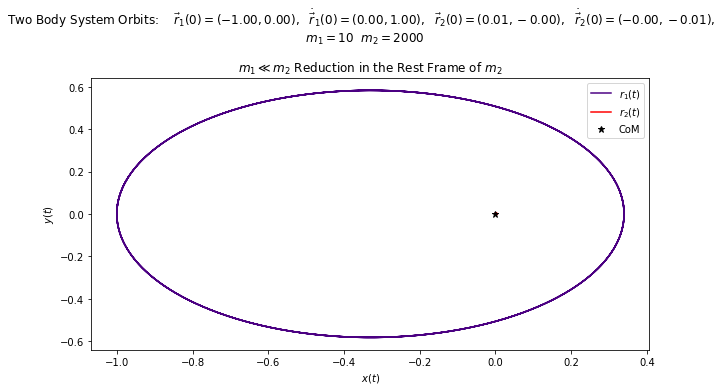

In [84]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x(t)$', r'$y(t)$')

fig = plt.figure(figsize=(10,5))
overall_title = 'Two Body System Orbits:  ' +  \
                 rf'  $  \vec {{r}}_1(0) = ({x_0[0]:.2f},{y_0[0]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_1(0) = ({x_dot_0[0]:.2f},{y_dot_0[0]:.2f}),$' +  \
                 rf'  $  \vec {{r}}_2(0) = ({x_0[1]:.2f},{y_0[1]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_2(0) = ({x_dot_0[1]:.2f},{y_dot_0[1]:.2f}),$' + \
                 '\n' + \
                 rf'  $m_1 = {m1:.0f}$' + \
                 rf'  $m_2 = {m2:.0f}$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

plot_y_vs_x(x1,y1, 
            axis_labels=x_vs_y_labels, 
            color='Indigo',
            label=r'$r_1(t)$', 
            title=r'$m_1 \ll m_2$ Reduction in the Rest Frame of $m_2$', 
            ax=ax_a)  
plot_y_vs_x(x2,y2, 
            axis_labels=x_vs_y_labels, 
            color='Red',
            label=r'$r_2(t)$', 
            ax=ax_a) 
# Adds the CoM point
ax_a.plot(0,0, 'ok', markersize = 7, marker = '*', label = "CoM")
ax_a.legend()

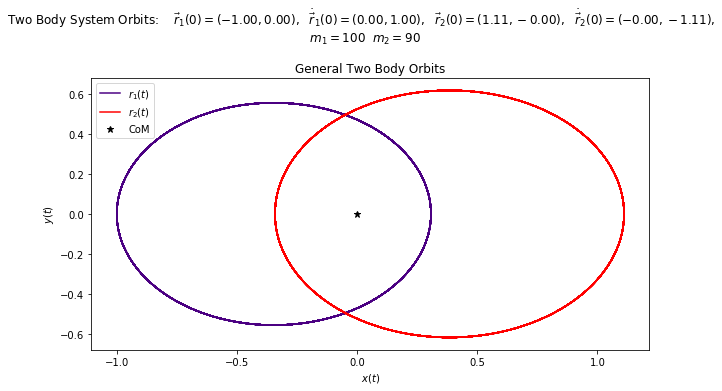

In [7]:
# Different Given Values
m1 = 100
m2 = 90
a = 1
b = 0
c = 0
d = 1
x_0 = [-a,m1/m2*a]
x_dot_0 = [b,-m1/m2*b]
y_0 = [c, -m1/m2*c]
y_dot_0 = [d, -m1/m2*d]

o2 = Orbit(G=G, m1 = m1, m2 = m1)
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode_Leapfrog(t_pts, x_0, x_dot_0, y_0, y_dot_0)
#orig = np.array(x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)

x1, y1, x2, y2 = fix_com(x1, y1, x2, y2, m1=m1, m2=m2)

# Labels for individual plot axes
x_vs_y_labels = (r'$x(t)$', r'$y(t)$')
#phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
#state_space_labels = (r'$\phi_1$', r'$d\phi_1/dt$')

fig = plt.figure(figsize=(10,5))
overall_title = 'Two Body System Orbits:  ' +  \
                 rf'  $  \vec {{r}}_1(0) = ({x_0[0]:.2f},{y_0[0]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_1(0) = ({x_dot_0[0]:.2f},{y_dot_0[0]:.2f}),$' +  \
                 rf'  $  \vec {{r}}_2(0) = ({x_0[1]:.2f},{y_0[1]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_2(0) = ({x_dot_0[1]:.2f},{y_dot_0[1]:.2f}),$' + \
                 '\n' + \
                 rf'  $m_1 = {m1:.0f}$' + \
                 rf'  $m_2 = {m2:.0f}$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

#start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1,y1, 
            axis_labels=x_vs_y_labels, 
            color='Indigo',
            label=r'$\vec r_1(t)$', 
            title='General Two Body Orbits', 
            ax=ax_a)  
plot_y_vs_x(x2,y2, 
            axis_labels=x_vs_y_labels, 
            color='Red',
            label=r'$\vec r_2(t)$', 
            #title=r'$\phi_2(t)$', 
            ax=ax_a) 
ax_a.plot(0,0, 'ok', markersize = 7, marker = '*', label = "CoM")
#ax_a.set_xlim([min_x-np.abs(0.1*min_x), max_x+0.1*max_x])
#ax_a.set_ylim([-abs_max/2, abs_max/2])
ax_a.legend()

### B) As seen from the two orbital graphs, the case where $m_1 \ll m_2$ will cause the heavy object to effectively become the center of mass, so its orbit will be very small in comparison to the light object. That being said, when this is not the case, the two objects will orbit around their shared center of mass. 

## Energy of Two Body Orbit  

$\begin{align}
    \Delta E_{tot} = 0 = E_{tot}(t) - E_{tot}(0)
\end{align}$  
Because energy is conserved, it should not increase nor decrease

In [8]:
# Generates values use solve_ivp then the leapfrog method
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, x_0, x_dot_0, y_0, y_dot_0)
e_tot = o2.energy(t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)
e_tot0 = e_tot[0]
e_tot_rel = abs((e_tot-e_tot0)/e_tot0) # Change in E

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode_Leapfrog(t_pts, x_0, x_dot_0, y_0, y_dot_0)

e_tot_leap = o2.energy(t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)
e_tot_leap0 = e_tot_leap[0]
e_tot_rel_leap = abs((e_tot_leap-e_tot_leap0)/e_tot_leap0) # Change in E

print("done")

done


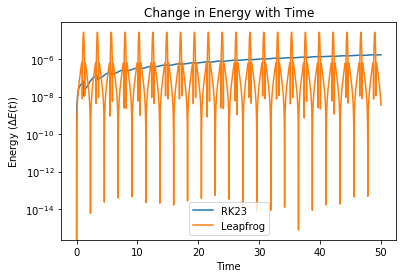

In [9]:
# Plots the energy of the orbits
plt.semilogy(t_pts, e_tot_rel, label = "RK23")
plt.semilogy(t_pts, e_tot_rel_leap, label = "Leapfrog")
plt.xlabel("Time")
plt.ylabel(r"Energy ($\Delta E(t)$)")
plt.title("Change in Energy with Time")
plt.legend()

### D) As seen by the above graph, the leapfrog technique for solving integrations will at times, be better than the regular ODE solver, but it will also have moments where it has greater error. Truth be told, they both seem to have relatively good approximation.

## Three Body Orbits:

Energy Within Three Body Orbital Mechanics  
$\begin{align}
     T(\mathbf{\dot r}) &= \frac 12 \sum m_i(\dot x_i^2 + \dot y_i^2) \\
     U(\mathbf{r}) &= -(\frac{G m_1 m_2}{\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}} +\frac{G m_1 m_3}{\sqrt{(x_1-x_3)^2+(y_1-y_3)^2}} +\frac{G m_2 m_3}{\sqrt{(x_2-x_3)^2+(y_2-y_3)^2}})
\end{align}$

The Lagrange's Equation:  
$\begin{align}
  \mathcal{L} &= T-U 
  \rightarrow \frac d{dt} \frac {\partial \mathcal L}{\partial\dot x_i}=\frac {\partial\mathcal L}{\partial x_i}  \\
\end{align}$

In [13]:
class Orbit3:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r).  Several algorithms for integration of 
    ordinary differential equations are now available. With them, the program 
    can simulate three body orbit slowly.
    """
    
    def __init__(self, ang_mom = 1, n = 1, k=1, m1=1., m2=1., m3=1., G = 1.):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3 
        self.G = G
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt, d^2y1/dt^2 dx2/dt d^2x2/dt^2 
        dy2/dt, d^2y2/dt^2 dx3/dt d^2x3/dt^2 dy3/dt, d^2y3/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            3-component vector with y[0] = x1(t), y[1] = dx1/dt, 
                                    y[2] = y1(t), y[3] = dy1/dt,
                                    y[4] = x2(t), y[5] = dx2/dt, 
                                    y[6] = y2(t), y[7] = dy2/dt,
                                    y[8] = x3(t), y[9] = dx3/dt, 
                                    y[10] = y3(t), y[11] = dy3/dt
            
        """
        G = self.G
        
        return [y[1], 
                -G*(self.m2*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))
                    +self.m3*((y[0]-y[8])*((y[0]-y[8])**2+(y[2]-y[10])**2)**(-3/2))), 
                y[3], 
                -G*(self.m2*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))
                    +self.m3*((y[2]-y[10])*((y[0]-y[8])**2+(y[2]-y[10])**2)**(-3/2))),
                y[5],
                G*(self.m1*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))
                   -self.m3*((y[4]-y[8])*((y[4]-y[8])**2+(y[6]-y[10])**2)**(-3/2))),
                y[7],
                G*(self.m1*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))
                   -self.m3*((y[6]-y[10])*((y[4]-y[8])**2+(y[6]-y[10])**2)**(-3/2))),
                y[9],
                G*(self.m2*((y[4]-y[8])*((y[4]-y[8])**2+(y[6]-y[10])**2)**(-3/2))
                   +self.m1*((y[0]-y[8])*((y[0]-y[8])**2+(y[2]-y[10])**2)**(-3/2))),
                y[11],
                G*(self.m2*((y[6]-y[10])*((y[4]-y[8])**2+(y[6]-y[10])**2)**(-3/2))
                   +self.m1*((y[2]-y[10])*((y[0]-y[8])**2+(y[2]-y[10])**2)**(-3/2)))]
    
    def solve_ode(self, t_pts, x_0, x_dot_0, y_0, y_dot_0, 
                  method='RK23', 
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions. To operate, give the function 
        the list of x_0, x_dot_0, y_0, and y_dot_0 where object 0 in the lists 
        is body 1. The function will output 4 sets of vectors in the given order. 
        Use solve_ivp with the option of specifying the method. Specify smaller 
        abserr and relerr to get more precision.
        """
        
        y = [x_0[0], x_dot_0[0], y_0[0], y_dot_0[0], 
             x_0[1], x_dot_0[1], y_0[1], y_dot_0[1],
             x_0[2], x_dot_0[2], y_0[2], y_dot_0[2]] 
                
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot
    
def fix_com3(x1, y1, x2, y2, x3, y3, m1=1., m2=1., m3=1.):
    """
    Fixed the center of mass for three bodies to the origin
    """
    com = np.array([(m1*x1+m2*x2+m3*x3)/(m1+m2+m3),(m1*y1+m2*y2+m3*y3)/(m1+m2+m3)])
    x1 = np.array(x1)-com[0]
    y1 = np.array(y1)-com[1]
    x2 = np.array(x2)-com[0]
    y2 = np.array(y2)-com[1]
    x3 = np.array(x3)-com[0]
    y3 = np.array(y3)-com[1]
    
    return x1, y1, x2, y2, x3, y3

In [63]:
t_start = 0.
t_end = 5.
delta_t = 0.001
t_pts = np.arange(t_start, t_end+delta_t, delta_t)

m1 = 100.
m2 = 90.
m3 = 5.
G =  .1#6.7 * 10**(-11)

a = 1
b = 0
c = 0
d = 4

x_0 = [-a,m1/m2*a, 0]
x_dot_0 = [b,-m1/m2*b, 0]
y_0 = [c, -m1/m2*c, 0]
y_dot_0 = [d, -m1/m2*d, 0]

o3 = Orbit3(m1=m1, m2=m2, m3=m3)
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot = o3.solve_ode(
    t_pts, x_0, x_dot_0, y_0, y_dot_0)

x1, y1, x2, y2, x3, y3 = fix_com3(x1, y1, x2, y2, x3, y3, m1=m1, m2=m2, m3=m3)

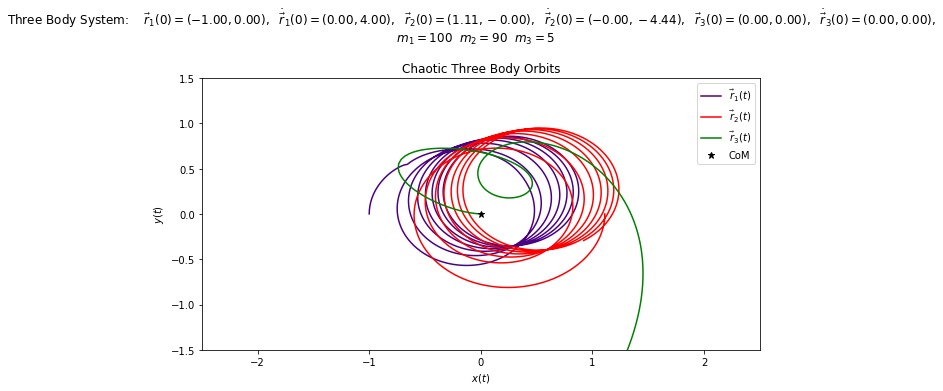

In [69]:
fig = plt.figure(figsize=(10,5))
overall_title = 'Three Body System:  ' +  \
                 rf'  $  \vec {{r}}_1(0) = ({x_0[0]:.2f},{y_0[0]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_1(0) = ({x_dot_0[0]:.2f},{y_dot_0[0]:.2f}),$' +  \
                 rf'  $  \vec {{r}}_2(0) = ({x_0[1]:.2f},{y_0[1]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_2(0) = ({x_dot_0[1]:.2f},{y_dot_0[1]:.2f}),$' + \
                 rf'  $  \vec {{r}}_3(0) = ({x_0[2]:.2f},{y_0[2]:.2f}),$' +  \
                 rf'  $  \dot{{\vec r}}_3(0) = ({x_dot_0[2]:.2f},{y_dot_0[2]:.2f}),$' + \
                 '\n' + \
                 rf'  $m_1 = {m1:.0f}$' + \
                 rf'  $m_2 = {m2:.0f}$' + \
                 rf'  $m_3 = {m3:.0f}$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

#start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1,y1, 
            axis_labels=x_vs_y_labels, 
            color='Indigo',
            label=r'$\vec r_1(t)$', 
            title='Chaotic Three Body Orbits', 
            ax=ax_a)  
plot_y_vs_x(x2,y2, 
            axis_labels=x_vs_y_labels, 
            color='Red',
            label=r'$\vec r_2(t)$', 
            #title=r'$\phi_2(t)$', 
            ax=ax_a) 
plot_y_vs_x(x3,y3, 
            axis_labels=x_vs_y_labels, 
            color='green',
            label=r'$\vec r_3(t)$', 
            #title=r'$\phi_2(t)$', 
            ax=ax_a) 
ax_a.plot(0,0, 'ok', markersize = 7, marker = '*', label = "CoM")
ax_a.set_xlim([-2.5,2.5])
ax_a.set_ylim([-1.5,1.5])
ax_a.legend()

### E) As apparent from several tests with the three bodies, it appears that it is very difficult to get a system within the simulation to remain non-chaotic. All attempts result in instability for all three bodies even with a fixed CoM.